# Optimization techniques Lab. 3: GD, BFGS and Newton methods
## Introduction
**Goal.** The goal of this laboratory is to study the application of local search algorithms on different benchmark functions.

We will see the Gradient Descent, the BFGS, and the Newton methods. Moreover, we will study how their parameters change the behavior of these algorithms. 

**Getting started.** The following code cell contains the core functions that we will use. Hence, remember to run it every time the Colab runtime is reconnected.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function. 
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)
5.   *trend*: show the best points find during the optmization process. 

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*). 
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or printing *dir(bf)*.




In [1]:
!pip3 install benchmark_functions
!pip install numdifftools

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 245.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 255.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 259.5 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 249.4 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 kB 263.2 kB/s eta 0:00:00a 0:00:01
Using legacy 'setup.py install' for algopy, since package 'wheel' is not installed.
  Running setup.py install for algopy ... done


In [3]:
import benchmark_functions as bf
from scipy.optimize import minimize, rosen, approx_fprime
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import derivative
import numdifftools as nd

class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []
        
    def __call__(self, x0):
        #if not type(x0) == 'list':
        #    x0 = [x0]
        self.history.append(x0.copy())
        return self.f(x0)

    def minima(self):
        return self.f.minimum()
    
    def cost(self):
        return len(self.history)

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())
    
    def gradient(self, x):
        return approx_fprime(x, self.f, epsilon=1.4901161193847656e-08)

    def heatmap(self, fn= None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        xdata = []
        ydata = []
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]

        x = np.linspace(bounds_lower[0] if len(xdata)== 0 or min(xdata)> bounds_lower[0] else min(xdata),
                        bounds_upper[0] if len(xdata)== 0 or max(xdata)< bounds_upper[0] else max(xdata),
                        resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1] if len(ydata)== 0 or min(ydata)> bounds_lower[1] else min(ydata),
                        bounds_upper[1] if len(ydata)== 0 or max(ydata)< bounds_upper[1] else max(ydata),
                        resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def trend(self, fn = None):
        plt.clf()
        showPoints = [x for x in self.history if self.in_bounds(x)]
        values = [self.f(list(v)) for v in showPoints]
        min = self.f.minimum().score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.legend()
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def in_bounds(self, p):
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        for i in range(len(p)):
            if p[i]<bounds_lower[i] or p[i]>bounds_upper[i]:
                return False
        return True
		

    def plot(self, fn = None):
        plt.clf()
        showPoints = [x for x in self.history if self.in_bounds(x)]
        xp = [h for h in showPoints]
        values = [self.f(v) for v in xp]
        min = self.f.minimum().score
        bounds = self.bounds()
        Dtmp = [np.linspace(bounds[i][0], bounds[i][1], num=1000) for i in range(len(bounds))]
        D = []
        for i in range(1000):
            D.append([Dtmp[j][i] for j in range(len(bounds))])
        C = []
        for i in range(1000):
            C.append(self.f([Dtmp[j][i] for j in range(len(bounds))]))
        plt.plot(D, C,  label = "function")
        plt.plot(xp, values,  '.', color="r", label="points")
        
        plt.legend()
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

def gradient_descent(f, x0, learn_rate, n_iter=50, tolerance=1e-06):
    x = x0
    f.history.append([v for v in x])
    for _ in range(n_iter):
        diff = -learn_rate * f.gradient(x)
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append([v for v in x])

    return x

def newton_method(f, x0, n_iter=50, tolerance=1e-06):
    x = np.array(x0)
    f.history.append(x.copy())
    f_jacob = nd.Jacobian(f.f)
    f_hess = nd.Hessian(f.f)
    for _ in range(n_iter):
        JA = f_jacob(x)
        HA = np.linalg.inv(f_hess(x))
        diff = -1*(JA.dot(HA)[0])
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append(x.copy())
    return x


def bfgs(f: OptFun, x0, eps: float, maxiter: int):
     """
     Optimizes a function by using the BFGS algorithm.

     - f: function to optimize, an instance of OptFun
     - x0: starting point for the search process
     - eps: step size for the update of the jacobian
     - maxiter: maximum number of iterations
     """
     return minimize(
         f,
         x0,
         method='BFGS',
         jac=None,
         options={
             'gtol': 1e-05,
             'norm': float('inf'),
             'eps': eps,
             "maxiter": maxiter,
             'disp': False,
             'return_all': True,
             'finite_diff_rel_step': None
         }
     )

# Ex. 1: Gradient Descent
---
In this first exercise, we will focus on the Gradient Descent algorithm.
* How the Learning Rate influences optimization?
* How does tolerance influences the search?
* The effects of these parameters are the same across different functions?


['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']


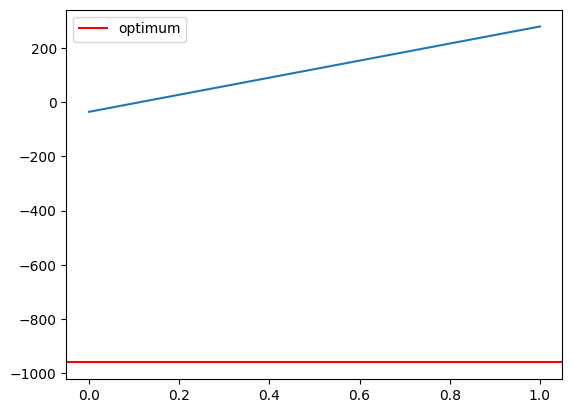

/tmp/ipykernel_15228/3707215317.py:35: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Benchmark Function: '+self.f._name)


<Figure size 640x480 with 0 Axes>

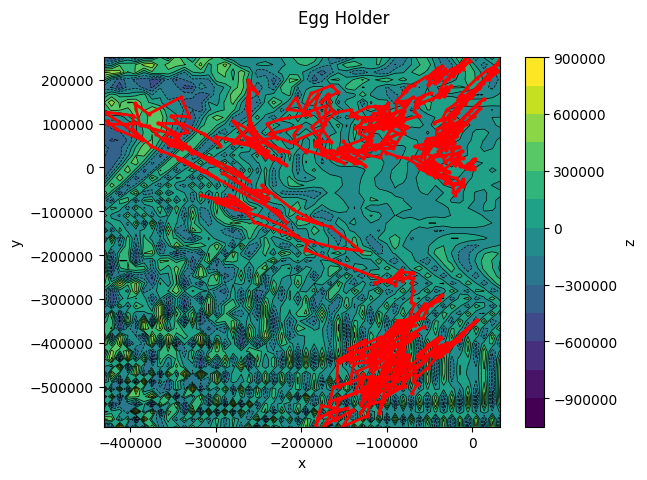

In [127]:
print(dir(bf))
func = OptFun(bf.EggHolder(2))

gradient_descent(func, np.array([-30., -60.]), 100, 1000, 1e-1)
func.trend()
func.heatmap()

# Ex. 2: Newton Method
---
In this exercise, we will see the Newton method.
Similar to the previous exercise, answer the following questions:

*   How does tolerance influence the search?
*   Is it faster to converge with respect to GD?
*   The result is similar across different functions?


['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']


/tmp/ipykernel_15228/3707215317.py:35: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Benchmark Function: '+self.f._name)


<Figure size 640x480 with 0 Axes>

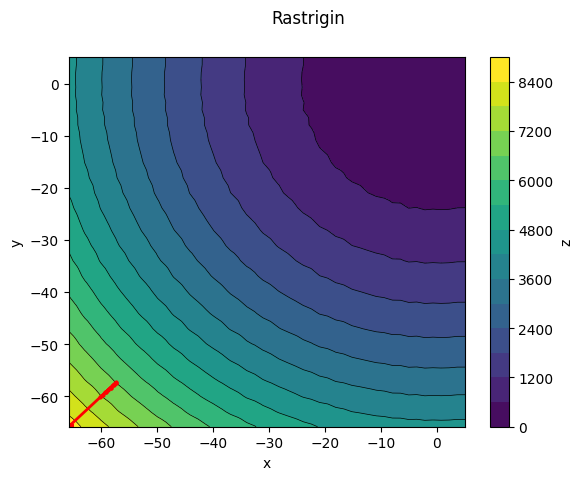

In [55]:
print(dir(bf))
func = OptFun(bf.Rastrigin(2))
newton_method(func, np.array([-60., -60.]), 1000, 1e-4)
func.heatmap()

# Ex. 3: BFGS  Optimization
---
In this exercise, we will focus on the BFGS optimization algorithm.
Similar to the previous exercise, answer the following questions:

* Varying these parameters what happens?
* How do they influence the evolution process?
* What is the difference with L-BFGS? Hint: you have to change the BFGSfunction, calling the right method to minimize. See [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb) the parameters available.


['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']


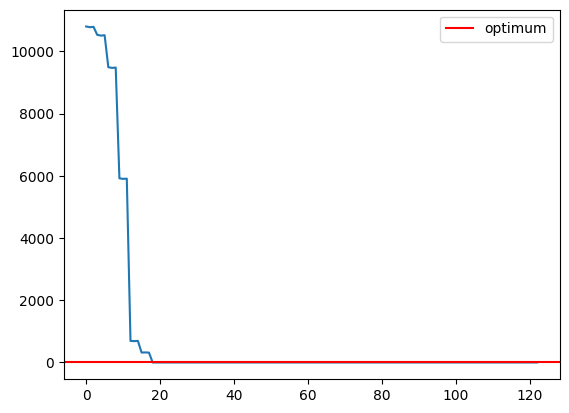

/tmp/ipykernel_15228/3707215317.py:35: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Benchmark Function: '+self.f._name)


<Figure size 640x480 with 0 Axes>

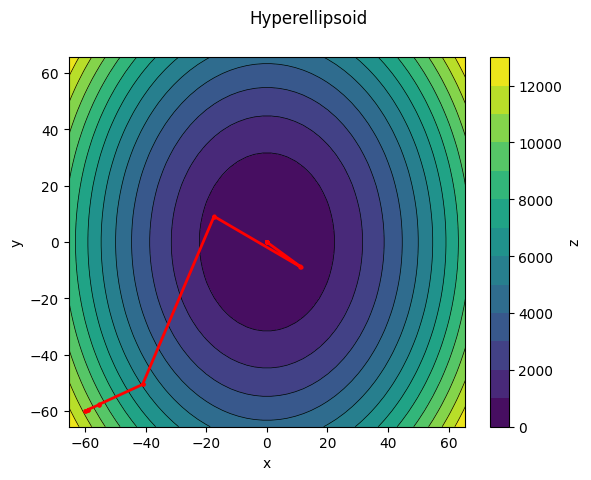

In [120]:
print(dir(bf))
func = OptFun(bf.Hyperellipsoid(2))

results = bfgs(func, [-60.,-60.], 0.1, 10000)
func.trend()
func.heatmap()

# Instructions and questions
---
Concisely note down your observations from the previous exercises (follow the bullet points) and
think about the following questions.
* What is the difference in search cost (the number of function/derivative evaluations) between these methods? 
* Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?  
 